In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time
import traceback
from scipy.spatial import distance as dist

In [2]:
target_names = ['person', 'laptop', 'chair', 'tvmonitor', 'diningtable']

In [71]:
class YOLOV3:
    def __init__(self, targets):
        self.objects = {name:[] for name in targets} # {target_name:[(id, box, center)]}
        self.target_names = targets
        self.objects_conf = {name:[] for name in self.target_names}
        self.net, self.output_layers, self.classes, self.targets = self.load_yolo(self.target_names)
        
    def load_yolo(self, targets):
        # Load Yolo
        net = cv2.dnn.readNet("yolov3.weights", "yolov3.cfg")
        net.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA)
        net.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
        with open("coco.names", "r") as f:
            classes = [line.strip() for line in f.readlines()]
        targets = np.array([np.where(np.array(classes) == target) for target in target_names]).flatten() # find index of wanted targets
        layer_names = net.getLayerNames()
        output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]
        
        return net, output_layers, classes, targets

    def detect_objects(self, size=(320,320), swapRB=True, crop=False, scalefactor=0.00392):
        # Detecting objects
        blob = cv2.dnn.blobFromImage(self.img, scalefactor, size, (0, 0, 0), swapRB, crop=crop)
        self.net.setInput(blob)
        outs = self.net.forward(self.output_layers)
    
        self.outs = outs
    
    # Showing informations on the screen
    def find_indexes(self, conf=0.9):
        self.class_ids = []
        self.confidences = []
        self.boxes = []
        self.centers = []
        dims = self.img.shape
        for out in self.outs:
            for detection in out:
                scores = detection[5:]
                class_id = np.argmax(scores)
                confidence = scores[class_id]
                if confidence > conf and class_id in self.targets:
                    # Object detected
                    center_x = int(detection[0] * dims[1])
                    center_y = int(detection[1] * dims[0])
                    w = int(detection[2] * dims[1])
                    h = int(detection[3] * dims[0])

                    # Rectangle coordinates
                    x = int(center_x - w / 2)
                    y = int(center_y - h / 2)

                    self.boxes.append([x, y, w, h])
                    self.centers.append((center_x, center_y))
                    self.confidences.append(float(confidence))
                    self.class_ids.append(class_id)

        self.indexes = cv2.dnn.NMSBoxes(self.boxes, self.confidences, 0.5, 0.4) # non max suppression
        
    def find_NMS_boxes(self):
        self.objects = {name:[] for name in self.target_names} # clear 'prev' objects
        #self.person_cof=[]
        self.distance = []
        tvmonitor_ids = []
        id_set = False
        try:
            for i,index in enumerate(self.indexes):
                label = str(self.classes[self.class_ids[index[0]]])
                box = self.boxes[index[0]]
                center = self.centers[index[0]]
                confidence = self.confidences[index[0]]
                self.objects_conf[label].append(confidence)
                if label == 'tvmonitor':
                    if id_set:
                        self.objects[label].append([tvmonitor_ids[i], box, center,confidence])# {target_name:[[id, [box], (center),confidence]}
                    else:
                        self.objects[label].append([index[0], box, center,confidence]) # {target_name:[[id, [box], (center),confidence]}
                        tvmonitor_ids.append(index[0])
                else:
                    self.objects[label].append([index[0], box, center,confidence]) # {target_name:[[id, [box], (center),confidence]}
        except KeyError:
            print('key '+ label + 'not found')

    def midpoint(self, ptA, ptB):
        return ((ptA[0] + ptB[0]) * 0.5, (ptA[1] + ptB[1]) * 0.5)
        
    def find_distance(self, target, reference, draw=False, mindistance=70, scalefactor=2.5):
        for trgt in self.objects[target]:
            target_objects = self.objects[reference]
            for ref in target_objects:
                ecdistance = dist.euclidean(trgt[2], ref[2])/2.5  # find distance from center of each object data (index 2)
                scaledistance = ecdistance / scalefactor
                if scaledistance < mindistance:
                    x=ref[1][0]
                    y=ref[1][1]
                    w=ref[1][2]
                    h=ref[1][3]
                    cv2.rectangle(self.img, (x, y), (x + w, y + h), (0, 0, 255), 2)
                if draw:
                    cv2.line(self.img, trgt[2], ref[2],(0, 0, 255), int(self.rect_thicc/2)+1)
                    xA,yA = trgt[2]
                    xB,yB = ref[2]
                    mX,mY = self.midpoint((xA, yA), (xB, yB))
                    cv2.putText(self.img, "{:.1f}in".format(scaledistance), (int(mX), int(mY - 10)), self.font, 
                                self.font_size, (0,0,255), self.font_width)
                    
                
    def draw_boxes_labels(self, colors=(0,255,0), labels_to_show=['tvmonitor', 'person']):
        self.font =cv2.FONT_HERSHEY_PLAIN
        height, width, dim = self.img.shape
        self.rect_thicc = int(height/140)
        if height < 140:
            rect_thicc = 1
        self.find_NMS_boxes()
        for label in self.target_names:
            if label in labels_to_show:
                for obj in self.objects[label]:   
                    x, y, w, h = obj[1] # obj[1] = box
                    self.font_size = int(height/400)+1
                    self.font_width = int(height/300)+1
                    lbl = label
                    color = colors
                    cv2.rectangle(self.img, (x, y), (x + w, y + h), color, int(self.rect_thicc))
                    cv2.circle(self.img, obj[2], self.rect_thicc*2, (0,255,0), thickness=int(self.rect_thicc/2)+1)
                    cv2.putText(self.img, lbl + str(obj[0]) + " "+"{:.1f}".format(obj[3]), (x, y - self.font_size), self.font, self.font_size, color, self.font_width)
                      
    def yolo_frame(self, img):
        fx=1.0
        fy=1.0
        self.scalemult=fx #scale for distance
        img = cv2.resize(img, None, fx=fx, fy=fy) # resize image
        self.img = img
        self.detect_objects() # find all objects
        self.find_indexes(.7) # box object if object in targets
        self.draw_boxes_labels() # update frame
        self.find_distance('person', 'tvmonitor', True, 200, scalefactor=2.5*self.scalemult) #scale the distance with size
        return img
    
    def yolo_video(self, filename):
        cap=cv2.VideoCapture(filename)
        if cap.isOpened() == False: 
            print("Error opening video stream or file")
        t1 = time.time()
        fps = .6 # initial fps
        try:
            while True:
                ret, img=cap.read()
                frame = cv2.resize(img, (768, 432)) 
                if time.time() - t1 > 1/fps:
                    t = time.time()
                    img = self.yolo_frame(img)
                    fps = 1/(time.time()-t) # find fps
                    cv2.putText(self.img, 'FPS: {0:.2f}'.format(fps), (0,15*self.font_size), self.font, self.font_size, (255,0,0), self.font_width)
                    #open final window
                    cv2.imshow('Feed', img)
                    t1 = time.time()
            #press q to quite the window
                if cv2.waitKey(25) & 0xFF == ord('q'):
                    break
        except:
            #traceback.print_exc() # print errors if there are any
            print('video or camera feed ended')
            pass
        finally:
            cap.release()
            cv2.destroyAllWindows()
            
    def graph_conf(self,label):
        valuelist=[]
        num = len(self.objects_conf[label])
        for i in range(num):
            valuelist.append(i)
        plt.plot(valuelist,self.objects_conf[label])
        plt.title('Total count vs. Confident Value')
        plt.xlabel('Total count')
        plt.ylabel('Confident Value')
        plt.grid()
        plt.show()

              

In [72]:
#img = cv2.imread('lab1.png')
YOLO = YOLOV3(target_names)
img = YOLO.yolo_frame(img)
#cv2.imwrite('out.jpg', img)
#plt.imshow(YOLO.yolo_frame(img))
YOLO.yolo_video(filename='conv2B training seats.mp4')

video or camera feed ended


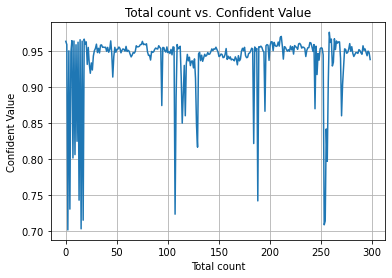

In [74]:
#Virtualization of confidence value
YOLO.graph_conf('tvmonitor')

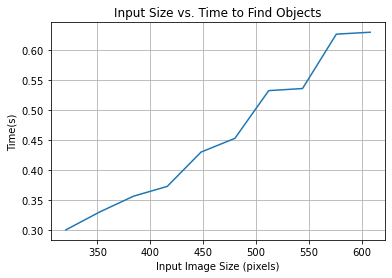

In [77]:
def find_exec_time(func, parameter):
    t0 = time.time()
    func(parameter)
    return time.time() - t0

sizes = []
times = []
for i in range(10):
    size = 320 + i*32
    if i >= 1:
        scalefactor= i*32*2.5
        YOLO.find_distance('person', 'tvmonitor', True, 200, scalefactor)
    t = find_exec_time(YOLO.detect_objects, (size,size))
    
    sizes.append(size)
    times.append(t)

plt.plot(sizes, times)
plt.title('Input Size vs. Time to Find Objects')
plt.xlabel('Input Image Size (pixels)')
plt.ylabel('Time(s)')
plt.grid()
plt.show()